# Step 3 – Train Model

This notebook is responsible for training the image classification model.
It will load the processed data, define the model architecture, set up the training loop, and save the trained model and relevant artifacts.

In [1]:
import sys
import os
from pathlib import Path
import importlib

# Add the project root to the Python path
# This allows importing modules from the 'src' directory
current_path = Path(os.getcwd()).resolve()
project_root = None
# Iterate up from current_path to its parents
for parent_dir in [current_path] + list(current_path.parents):
    if (parent_dir / ".git").is_dir() or (parent_dir / "pyproject.toml").is_file() or (parent_dir / "src").is_dir():
        project_root = parent_dir
        break

if project_root is None:
    # Fallback for structures where notebook is in 'notebooks' dir directly under project root
    if current_path.name == "notebooks" and (current_path.parent / "src").is_dir():
        project_root = current_path.parent
    else:
        # Default to current_path if specific markers or 'notebooks' structure isn't found
        project_root = current_path
        print(f"Warning: Could not reliably find project root. Using CWD: {project_root}. Ensure 'src' is in python path.")

if project_root:
    project_root_str = str(project_root)
    if project_root_str not in sys.path:
        sys.path.insert(0, project_root_str)
        print(f"Project root '{project_root_str}' added to sys.path.")
    else:
        print(f"Project root '{project_root_str}' is already in sys.path.")
else:
    print("Error: Project root could not be determined. Imports from 'src' may fail.")

# Reload modules to ensure the latest changes are picked up
# Useful if you're actively developing the src modules
import src.config
import src.data.loader
import src.models.model
import src.utils.seed
import src.utils.plot

importlib.reload(src.config)
importlib.reload(src.data.loader)
importlib.reload(src.models.model)
importlib.reload(src.utils.seed)
importlib.reload(src.utils.plot)

Project root '/workspaces/photo_tag_pipeline' added to sys.path.


/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'src.utils.plot' from '/workspaces/photo_tag_pipeline/src/utils/plot.py'>

[INFO] Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)


Using device: cpu
TrainConfig: TrainConfig(epochs=5, seed=42, early_stop_patience=3, batch_size=32, num_workers=2)
ModelConfig: ModelConfig(backbone='resnet18', pretrained=True, drop_rate=0.0, num_classes=None)
OptimConfig: OptimConfig(optim='adamw', lr=0.0003, weight_decay=0.0001, momentum=0.9)
Seed set to 42
Loading data...
Data loaded. Train batches: 1, Val batches: 1
Building model...
Number of classes loaded from metadata: 2


[INFO] [timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
[INFO] Missing keys (fc.weight, fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


Model, criterion, and optimizer created.
Starting training for 5 epochs...


Epoch 1/5 [Training]:   0%|          | 0/1 [00:00<?, ?batch/s]/usr/local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 1/5 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.19s/batch, loss=0.692]


Epoch 1/5 - Train Loss: 0.6991, Val Loss: 0.6923
New best model saved to /workspaces/photo_tag_pipeline/checkpoints/best_model_notebook.pth (Val Loss: 0.6923)


Epoch 2/5 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.00s/batch, loss=0.693]


Epoch 2/5 - Train Loss: 0.6755, Val Loss: 0.6929


Epoch 3/5 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.23s/batch, loss=0.701]


Epoch 3/5 - Train Loss: 0.6645, Val Loss: 0.7006


Epoch 4/5 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.15s/batch, loss=0.712]


Epoch 4/5 - Train Loss: 0.6399, Val Loss: 0.7124


Epoch 5/5 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.10s/batch, loss=0.719]


Epoch 5/5 - Train Loss: 0.6244, Val Loss: 0.7189
Final model saved to /workspaces/photo_tag_pipeline/checkpoints/final_model_notebook.pth
Loss curve saved to /workspaces/photo_tag_pipeline/results/loss_curve_notebook.png
Training complete.


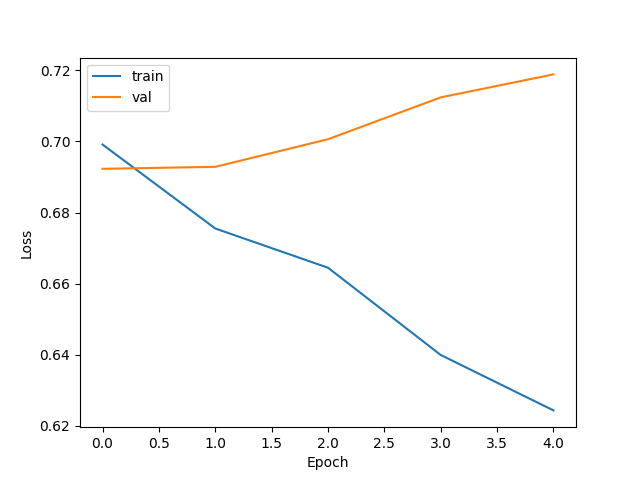

In [2]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm # For progress bars

# Imports from our src directory
from src.config import ModelConfig, OptimConfig, TrainConfig, CHECKPOINT_DIR, RESULTS_DIR
from src.data.loader import load_data
from src.models.model import build_model
from src.utils.seed import set_seed
from src.utils.plot import save_loss_plot

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# ---- Configurations ----
mcfg = ModelConfig()
ocfg = OptimConfig()
tcfg = TrainConfig() # Uses default epochs, can be overridden

# You can override config parameters here if needed for experimentation
# For example:
# tcfg.epochs = 5 
# ocfg.lr = 0.0005

print(f"TrainConfig: {tcfg}")
print(f"ModelConfig: {mcfg}")
print(f"OptimConfig: {ocfg}")

# ---- Set Seed ----
set_seed(tcfg.seed)
print(f"Seed set to {tcfg.seed}")

# ---- Data Loaders ----
print("Loading data...")
# load_data uses paths from src.config (DATASET_ROOT)
# and batch_size, num_workers from tcfg.
train_loader, val_loader = load_data(batch_size=tcfg.batch_size, num_workers=tcfg.num_workers)
print(f"Data loaded. Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

# ---- Model, Loss, Optimizer ----
print("Building model...")
# build_model uses mcfg (num_classes, pretrained)
# It also needs to know the number of classes from the dataset if not fixed in ModelConfig
# Assuming ModelConfig.num_classes is correctly set (e.g., via dataset_metadata.json or a fixed value)
# If your dataset_metadata.json is up-to-date from 01_dataset_eda, ModelConfig should load num_classes from there.
# If not, ensure mcfg.num_classes is correct.
if mcfg.num_classes is None:
    # Attempt to get num_classes from the dataset if not set in config
    # This requires dataset_metadata.json to be present and correct
    try:
        import json
        metadata_path = src.config.META_PATH
        if metadata_path.exists():
            with open(metadata_path, 'r') as f:
                metadata = json.load(f)
            mcfg.num_classes = metadata.get('num_classes')
            print(f"Number of classes loaded from metadata: {mcfg.num_classes}")
        else:
            raise FileNotFoundError("Metadata file not found, num_classes not set.")
        if mcfg.num_classes is None:
             raise ValueError("num_classes is None even after trying to load from metadata.")
    except Exception as e:
        print(f"Error loading num_classes from metadata: {e}. Please ensure ModelConfig.num_classes is set or metadata is correct.")
        # Fallback or raise error
        # mcfg.num_classes = len(src.config.DEFAULT_CLASSES) # Example fallback
        # print(f"Falling back to num_classes: {mcfg.num_classes}")
        raise e


model = build_model(mcfg).to(DEVICE)
criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy for multi-label
optimizer = optim.AdamW(model.parameters(), lr=ocfg.lr, weight_decay=ocfg.weight_decay)
print("Model, criterion, and optimizer created.")

# ---- Training Loop ----
best_val_loss = float('inf')
train_losses, val_losses = [], []

print(f"Starting training for {tcfg.epochs} epochs...")
for epoch in range(tcfg.epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{tcfg.epochs} [Training]", unit="batch")
    for imgs, labels in progress_bar:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # ---- Validation ----
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        progress_bar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{tcfg.epochs} [Validation]", unit="batch")
        for imgs, labels in progress_bar_val:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            progress_bar_val.set_postfix(loss=loss.item())
            
    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{tcfg.epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # ---- Checkpoint ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_path = CHECKPOINT_DIR / "best_model_notebook.pth"
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved to {best_model_path} (Val Loss: {best_val_loss:.4f})")

# ---- Save Final Model ----
final_model_path = CHECKPOINT_DIR / "final_model_notebook.pth"
torch.save(model.state_dict(), final_model_path)
print(f"Final model saved to {final_model_path}")

# ---- Plot and Save Loss Curve ----
loss_plot_path = RESULTS_DIR / "loss_curve_notebook.png"
# Ensure results directory exists (though config should handle it)
RESULTS_DIR.mkdir(parents=True, exist_ok=True) 
save_loss_plot(train_losses, val_losses, str(loss_plot_path))
print(f"Loss curve saved to {loss_plot_path}")

print("Training complete.")
# Display the plot in the notebook
from IPython.display import Image
if loss_plot_path.exists():
    display(Image(filename=str(loss_plot_path)))
else:
    print(f"Could not find loss plot at {loss_plot_path} to display.")


After training, the model will be saved to the `checkpoints/` directory (e.g., `best_model_notebook.pth`, `final_model_notebook.pth`), and the loss curve plot will be saved in the `results/` directory (e.g., `loss_curve_notebook.png`).

In [ ]:
# Export notebook to HTML

# Add this tag to the cell metadata to exclude it from exports
# Add the following to the cell metadata: {"tags": ["remove"]}

import nbformat
from nbconvert import HTMLExporter
import os

# Get the current notebook name
notebook_path = "03_train_model.ipynb"
html_path = notebook_path.replace(".ipynb", ".html")

# Load the notebook
with open(notebook_path, 'r', encoding='utf-8') as f:
    notebook = nbformat.read(f, as_version=4)

# Create HTMLExporter
html_exporter = HTMLExporter()
html_exporter.exclude_tag_names = ['remove']  # This will exclude cells with 'remove' tag

# Convert to HTML
(body, resources) = html_exporter.from_notebook_node(notebook)

# Write to HTML file
with open(html_path, 'w', encoding='utf-8') as f:
    f.write(body)

print(f"Notebook exported to {html_path}")